In [1]:
%matplotlib inline
import pysal as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN

In [2]:
requests_link = "./data/311_requests.csv"
requests = pd.read_csv(requests_link)
requests.head()

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source
0,101002075589,2017-04-29 00:02:48,2017-05-02 08:30:00,NaN,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3594,-71.0587,Citizens Connect App
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,NaN,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App
2,101002075587,2017-04-28 23:55:28,2017-05-02 08:30:00,NaN,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3331,-71.0535,Citizens Connect App
3,101002075585,2017-04-28 23:15:15,2017-05-08 08:30:00,NaN,ONTIME,Open,Litter / Ground Maintenance - Peters Park (BPRD),Parks & Recreation Department,Park Maintenance & Safety,Ground Maintenance,PARK_Maintenance_Region 5,PARK,42.3431,-71.0683,Citizens Connect App
4,101002075578,2017-04-28 23:03:20,2017-05-02 08:30:00,NaN,ONTIME,Open,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,Sidewalk Repair (Make Safe),PWDx_Contractor Complaints,PWDx,42.3421,-71.0835,Citizens Connect App


In [3]:
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65499 entries, 0 to 65498
Data columns (total 15 columns):
CASE_ENQUIRY_ID    65499 non-null int64
open_dt            65499 non-null object
target_dt          57474 non-null object
closed_dt          56036 non-null object
OnTime_Status      65497 non-null object
CASE_STATUS        65499 non-null object
CASE_TITLE         65498 non-null object
SUBJECT            65499 non-null object
REASON             65499 non-null object
TYPE               65499 non-null object
QUEUE              65499 non-null object
Department         65499 non-null object
Latitude           65499 non-null float64
Longitude          65499 non-null float64
Source             65499 non-null object
dtypes: float64(2), int64(1), object(12)
memory usage: 7.5+ MB


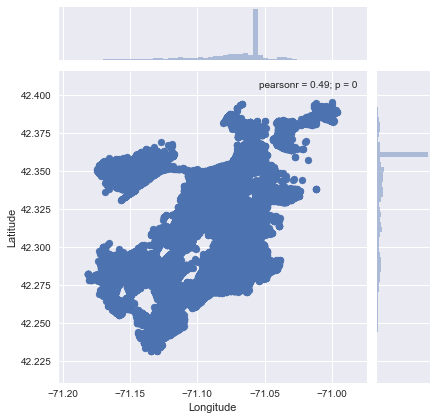

In [4]:
sns.jointplot(x="Longitude", y="Latitude", data=requests)

In [5]:
# almost 18,000 requests are being geocoded to the same place
tmp = requests.groupby('Longitude').count().sort_values(by='open_dt',ascending=False)
#tmp

In [6]:
# pull out those requests and take it out for now
odd = requests.loc[(requests.Latitude==42.3594) & (requests.Longitude==-71.0587), ['Longitude', 'Latitude']]
requests_tmp = requests.drop(odd.index)
print(requests_tmp.shape)
print(requests.shape)

(47980, 15)
(65499, 15)


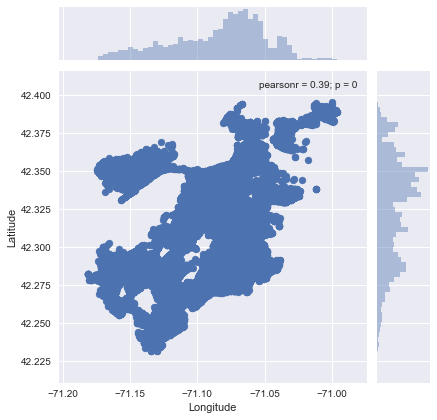

In [7]:
sns.jointplot(x="Longitude", y="Latitude", data=requests_tmp)

In [8]:
# plot with bokeh
xys_wb = gpd.GeoSeries(requests_tmp[['Longitude', 'Latitude']].apply(Point, axis=1), \
                      crs="+init=epsg:4326")

In [9]:
xys_wb = xys_wb.to_crs(epsg=3857)

In [10]:
x_wb = xys_wb.apply(lambda i: i.x)
y_wb = xys_wb.apply(lambda i: i.y)

In [11]:
minx, miny, maxx, maxy = xys_wb.total_bounds
y_range = miny, maxy
x_range = minx, maxx

def base_plot(tools='pan,wheel_zoom,reset',plot_width=600, plot_height=400, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

options = dict(line_color=None, fill_color='#800080', size=4)

In [12]:
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
p.circle(x=x_wb, y=y_wb, **options)
show(p)

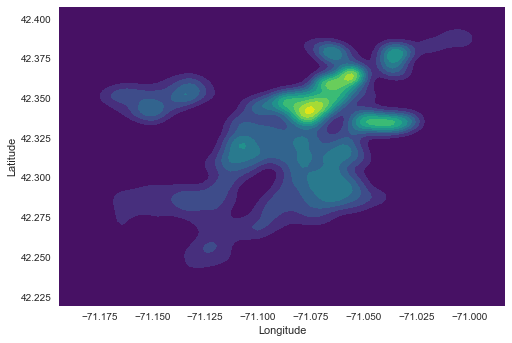

In [13]:
# create density map and plot on to block groups
sns.kdeplot(requests_tmp['Longitude'], requests_tmp['Latitude'], shade=True, cmap='viridis');

In [14]:
cb = gpd.read_file('./data/census2000blockgroups_poly/census2000blockgroups_poly.shp')
#cb.plot();

INFO:Fiona:Failed to auto identify EPSG: 7


In [15]:
cb.head()

,AREA,BG_ID,BLK_COUNT,BLOCKGROUP,COUNTY,CT_ID,DRY_ACRES,DRY_PCT,DRY_SQKM,DRY_SQMI,LOGRECNO,OBJECTID,PERIMETER,SAMP_POP,SHAPE_AREA,SHAPE_LEN,STATE,TOTAL_POP,TRACT,geometry
0,2.265785e+07,250010101001,50,1,001,25001010100,5475.69,0.978,22.16,8.556,0000857,1,46575.6958,761,2.265785e+07,46575.724671,25,771,010100,"(POLYGON ((307967.6206393589 868006.369694391,..."
1,1.367193e+06,250010101002,21,2,001,25001010100,337.84,1.000,1.37,0.528,0000858,2,6457.5456,555,1.367198e+06,6457.535406,25,567,010100,"POLYGON ((309210.070639359 868670.9996943909, ..."
2,4.780045e+05,250010101003,18,3,001,25001010100,118.12,1.000,0.48,0.185,0000859,3,2814.8582,653,4.780061e+05,2814.864636,25,647,010100,"POLYGON ((309063.410639359 867967.4496943911, ..."
3,6.619485e+05,250010101004,17,4,001,25001010100,163.57,1.000,0.66,0.256,0000860,4,4824.9766,654,6.619481e+05,4824.965741,25,646,010100,"POLYGON ((308892.800639359 867987.6996943911, ..."
4,3.508943e+05,250010101005,31,5,001,25001010100,86.71,1.000,0.35,0.135,0000861,5,3409.1147,808,3.508944e+05,3409.117728,25,800,010100,"POLYGON ((308086.640639359 867375.569694391, 3..."


In [16]:
suffolk = cb.loc[cb['COUNTY'] == '025']

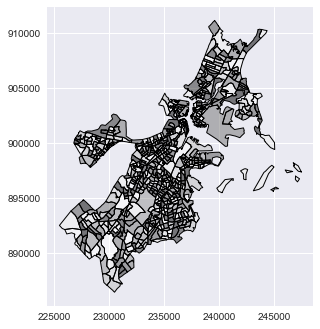

In [17]:
suffolk.plot()

In [18]:
suffolk.crs
suffolk = suffolk.to_crs({'init': 'epsg:4326'})

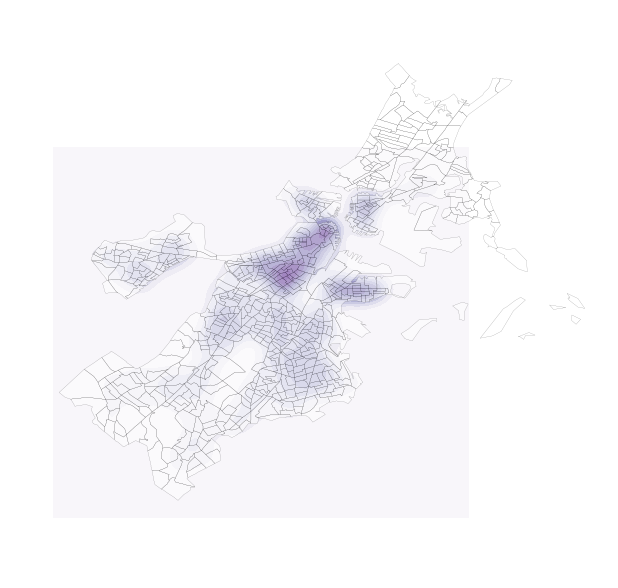

In [19]:
f, ax = plt.subplots(1, figsize=(10, 10))

suffolk.plot(color='white', linewidth=0.1, ax=ax)

sns.kdeplot(requests_tmp['Longitude'], requests_tmp['Latitude'], \
            shade=True, cmap='Purples', \
            ax=ax);

ax.set_axis_off()
plt.axis('equal')
plt.show()